In [1]:
import pandas as pd
from pandas.errors import OutOfBoundsDatetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

from src.utils import read_jsonl, write_jsonl
from src.visualization.visualize import paper_mpl_env, title
import textwrap
import numpy as np
import os

%load_ext autoreload
%autoreload 2

## GPT-4 Scenarios

In [2]:
# Prompt asks for shorter summaries and simpler siuations
v2_data = pd.read_json('/gscratch/bdata/datasets/llms_and_timeseries/v2_MCQ.json',lines=True)

### Extract Categories

In [3]:
categories = pd.read_json("categorized_output.json",lines=True)[["uuid","category"]]
categories.rename(columns={"category":"scenario_category"}, inplace=True)
categories["scenario_category"] = categories["scenario_category"].str.split("Category:").str[-1].str.strip().str.removeprefix("'").str.removesuffix("'")

top_ten = categories["scenario_category"].value_counts().head(10).index.to_list()
categories = categories[categories["scenario_category"].isin(top_ten)]
categories.to_csv("data/processed/scenario_categories.csv",index=False)

In [4]:
categorised_data = v2_data.join(categories.set_index("uuid"),on="uuid", how="inner")

In [5]:
categorised_data

,description,description_short,description_tiny,characteristics,generator,metadata,series,uuid,category,question,options,answer_index,ts_qid,scenario_category
0,A scientist is measuring the temperature in a...,A temperature reading from an industrial free...,Freezer Temperature Time Series,\n1) Continuous increment of temperature duri...,\n```python\nimport numpy as np\ndef generate...,"{'start': '2022-03-01 00:00:00', 'end': '2022-...","[20.88202617298383, 20.200078604183613, 20.489...",f1e0cf26-8707-4e47-a64e-0a51c1867cc6,time-series,What was the lowest temperature recorded durin...,"[18.61 degrees, 20.52 degrees, 12.34 degrees, ...",0,0,Agricultural and Food Production
0,A scientist is measuring the temperature in a...,A temperature reading from an industrial free...,Freezer Temperature Time Series,\n1) Continuous increment of temperature duri...,\n```python\nimport numpy as np\ndef generate...,"{'start': '2022-03-01 00:00:00', 'end': '2022-...","[20.88202617298383, 20.200078604183613, 20.489...",f1e0cf26-8707-4e47-a64e-0a51c1867cc6,time-series,What was the lowest temperature recorded durin...,"[18.61 degrees, 20.52 degrees, 12.34 degrees, ...",0,0,Agricultural and Food Production
0,A scientist is measuring the temperature in a...,A temperature reading from an industrial free...,Freezer Temperature Time Series,\n1) Continuous increment of temperature duri...,\n```python\nimport numpy as np\ndef generate...,"{'start': '2022-03-01 00:00:00', 'end': '2022-...","[20.88202617298383, 20.200078604183613, 20.489...",f1e0cf26-8707-4e47-a64e-0a51c1867cc6,time-series,What was the lowest temperature recorded durin...,"[18.61 degrees, 20.52 degrees, 12.34 degrees, ...",0,0,Energy and Resource Consumption
0,A scientist is measuring the temperature in a...,A temperature reading from an industrial free...,Freezer Temperature Time Series,\n1) Continuous increment of temperature duri...,\n```python\nimport numpy as np\ndef generate...,"{'start': '2022-03-01 00:00:00', 'end': '2022-...","[20.88202617298383, 20.200078604183613, 20.489...",f1e0cf26-8707-4e47-a64e-0a51c1867cc6,time-series,What was the lowest temperature recorded durin...,"[18.61 degrees, 20.52 degrees, 12.34 degrees, ...",0,0,Energy and Resource Consumption
0,A scientist is measuring the temperature in a...,A temperature reading from an industrial free...,Freezer Temperature Time Series,\n1) Continuous increment of temperature duri...,\n```python\nimport numpy as np\ndef generate...,"{'start': '2022-03-01 00:00:00', 'end': '2022-...","[20.88202617298383, 20.200078604183613, 20.489...",f1e0cf26-8707-4e47-a64e-0a51c1867cc6,time-series,What was the lowest temperature recorded durin...,"[18.61 degrees, 20.52 degrees, 12.34 degrees, ...",0,0,Energy and Resource Consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197291,"\nOver a period of two years, the time series ...",\nThe time series examines the daily footfall ...,\nMovie theater footfall\n,\n1. The time series would typically show a we...,\n```python\nimport numpy as np\nimport panda...,"{'start': '2020-01-01', 'end': '2021-12-31', '...","[1041.2476339148154, 1765.7337117815525, 4652....",c557e137-9da2-4126-8826-906f251ec49f,description,How many days are included in the time series ...,[A time series of length 3650 days representin...,1,15,Recreational and Entertainment Trends
197292,"\nOver a period of two years, the time series ...",\nThe time series examines the daily footfall ...,\nMovie theater footfall\n,\n1. The time series would typically show a we...,\n```python\nimport numpy as np\nimport panda...,"{'start': '2020-01-01', 'end': '2021-12-31', '...","[1041.2476339148154, 1765.7337117815525, 4652....",c557e137-9da2-4126-8826-906f251ec49f,counterfactual,What would happen to the timeseries if the the...,[The timeseries would show a decline in the lo...,2,16,Recreational and Entertainment Trends
197293,"\nOver a period of two years, the time series ...",\nThe time series examines the daily footfall ...,

### Examples

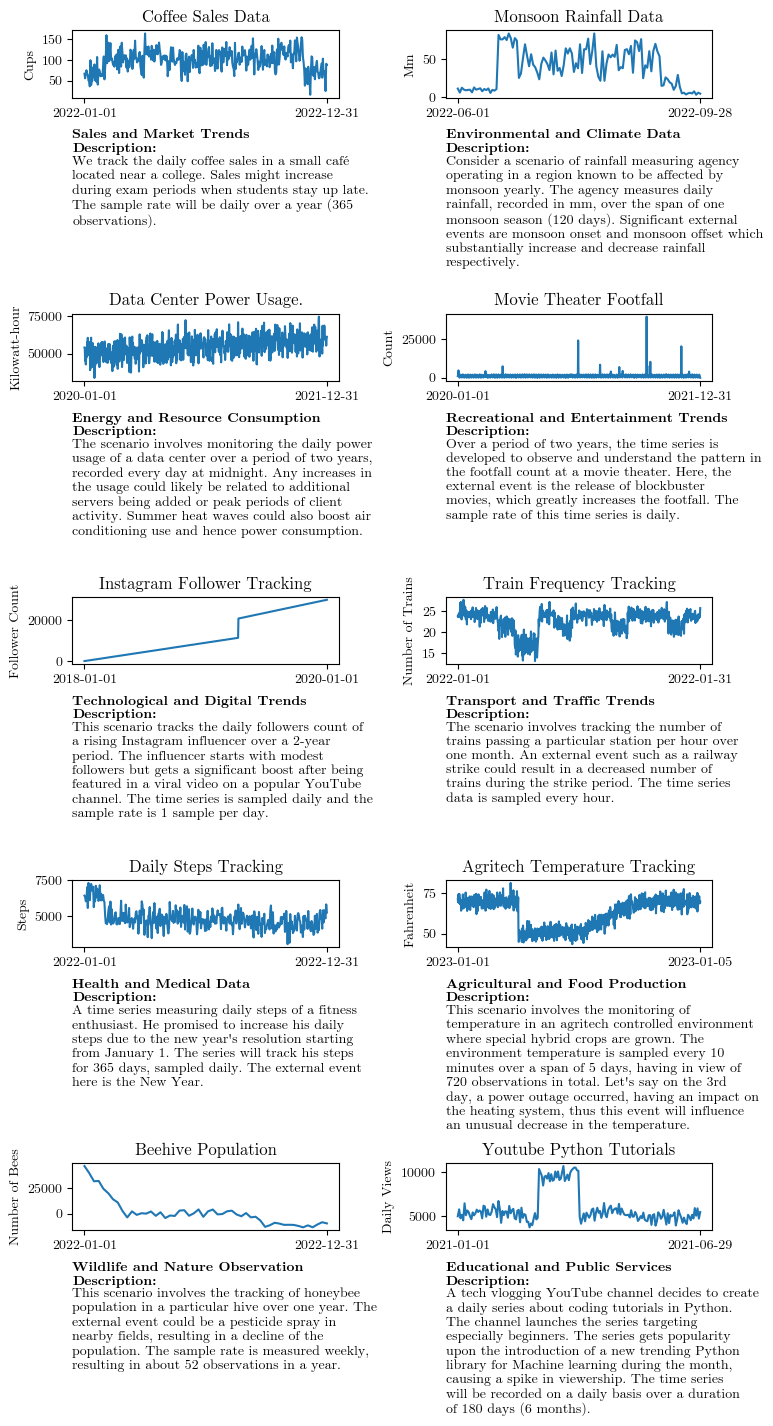

In [42]:
one_of_each = categorised_data.groupby("scenario_category").last().reset_index()
with paper_mpl_env():    
    fig1, axes = plt.subplots(5, 2, figsize=(8, 40))
    axes = axes.flatten()
    i=0
    i_start=0
    n_plotted = 0
    cat_counts = categorised_data['scenario_category'].value_counts().rename('counts')
    one_of_each = one_of_each.join(cat_counts, on='scenario_category')
    one_of_each.sort_values(by = "counts", ascending=False, inplace=True)
    
    cmap = iter(cm.tab10(np.linspace(0,1,10)))
    while n_plotted < 10:
        sample = one_of_each.iloc[i]
        ts = sample['series']
        desciption = sample['description']
        desciption_tiny = title(sample['description_tiny'])
        start = sample['metadata']['start']
        end = sample['metadata']['end']
        units = title(sample['metadata']['units'])
        category = sample['scenario_category']
        # color = next(cmap)
        color = None

        try:
            x = pd.date_range(start=start, end=end, periods=len(ts))
        except OutOfBoundsDatetime:
            x = range(len(ts))
            print("Warning: OutOfBoundsDatetime")
            i+=1
            continue
        

        axes[n_plotted].plot(x,ts, color=color)
        axes[n_plotted].set_title(desciption_tiny.strip())
        axes[n_plotted].text(0, -0.6, category, fontsize=10, transform=axes[n_plotted].transAxes, fontweight='bold', ha='left')
        # Put bold text that says "Description: above the description"
        axes[n_plotted].text(0, -.8, "Description:", fontsize=10, transform=axes[n_plotted].transAxes, fontweight='bold', ha='left')
        # Put description in box to the right of each subplot (with text wrapping)
        axes[n_plotted].text(0, -.85, textwrap.fill(desciption.strip(), 50), fontsize=10, transform=axes[n_plotted].transAxes, va='top')
        # Set xticks to just first and last
        axes[n_plotted].set_xticks([x[0], x[-1]])
        axes[n_plotted].set_ylabel(units)
        i += 1
        n_plotted += 1

    fig1.subplots_adjust(left=0.1,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.7, 
                    wspace=0.4, 
                    hspace=3.2)
    # fig1.tight_layout() 
    fig1.savefig("reports/2024/one_of_each.pdf",bbox_inches='tight')
fig1



### Donut Plot

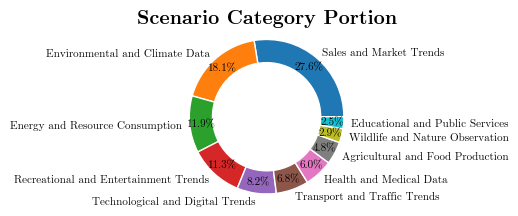

In [9]:

with paper_mpl_env():
    fig2, ax = plt.subplots(figsize=(4, 2))
    category_portions = categorised_data["scenario_category"].value_counts(normalize=True)
    plt.pie(category_portions, labels=category_portions.index, autopct='%1.1f%%', startangle=0, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 1},
            textprops={'fontsize': 8},
            pctdistance=0.85)
    # add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    plt.tight_layout()
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
    plt.title('Scenario Category Portion', fontsize=14, fontweight='bold')
    plt.savefig("reports/2024/category_portion.pdf", bbox_inches='tight')
fig2

### Comparison of generation styles

In [4]:
# Select the description that was also passed to gpt-4
print(v2_data[v2_data["description"].str.contains("daily productivity in terms of tasks completed")]["characteristics"].iloc[0])


1. Overall, there may be a positive trend in productivity as the employee gains more experience and skill.
2. Decreased productivity might be detected during weekends when the employee is not working.
3. Potential seasonal patterns could be identified, such as slowdowns during periods of leave/vacation or around public holidays.
4. Annual holiday season (November-December) is expected to lead to a dip in productivity.
5. The post-holiday period in January might show an increase in productivity as the employee returns fully engaged.



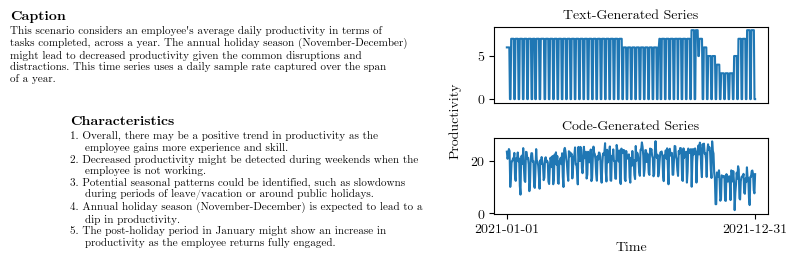

In [11]:
example = v2_data[v2_data["description"].str.contains("daily productivity in terms of tasks completed")].iloc[0]
code_generated_series = example["series"]
metadata = example["metadata"]
start = metadata["start"]
end = metadata["end"]

text_generated_series = productivity = [
    # January (starting from post-holiday engagement)
    6, 6, 6, 6, 6, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7,
    # February (the skill is growing, small increments)
    7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7,   
    # March (increment in average productivity)
    7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0,
    # April
    7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7,
    # May (continuing the growth trend)
    7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0,
    # June
    0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7,
    # July (entering vacation period, small dip)
    7, 7, 7, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0,
    # August (vacation effect lingers)
    0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 0, 0, 6, 6,
    # September (productivity is recovering)
    7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7,
    # October (full recovery and growth)
    0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 8, 8, 8, 8, 8, 0, 0, 8, 8, 8,
    # November (beginning of holiday decline)
    8, 5, 5, 7, 7, 7, 7, 7, 0, 0, 6, 6, 6, 6, 6, 0, 0, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 0, 0,
    # December (lowest productivity period)
    4, 4, 4, 4, 4, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 5, 5, 5, 5,
    # January (post-holiday surge)
    5, 0, 0, 7, 7, 7, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 0, 8, 8, 8, 8, 8, 0, 0, 8, 8, 8, 8, 8, 0, 0
]

with paper_mpl_env():
    # Plotting the text generated series
    
    
    fig3, axes3 = plt.subplots(2,1,figsize=(4, 3))
    plt.cla()
    axes3 = axes3.flatten()

    x = pd.date_range(start=start, end=end, periods=len(text_generated_series))
    axes3[0].plot(x,text_generated_series)
    axes3[0].set_title('Text-Generated Series', fontsize=10)
    axes3[0].set_xlabel('')
    axes3[0].set_ylabel('')
    axes3[0].set_xticks([])


    # Plotting the code generated series
    x = pd.date_range(start=start, end=end, periods=len(code_generated_series))
    axes3[1].plot(x,code_generated_series)
    axes3[1].set_title('Code-Generated Series', fontsize=10)
    axes3[1].set_xlabel('Time')
    axes3[1].set_ylabel('')
    axes3[1].set_xticks([x[0], x[-1]])

    fig3.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # plt.xlabel("common X")
    plt.ylabel("Productivity")
    

    TEXT_WIDTH=80
    PAD_SPACES = 4
    
    desciption = example['description']
    fig3.text(-1, 0.90, "Caption", fontsize=10,  fontweight='bold', ha='left')
    fig3.text(-1, 0.88, textwrap.fill(desciption.strip(),TEXT_WIDTH), fontsize=8, ha='left', va = "top")
    fig3.text(-.85, 0.55, "Characteristics", fontsize=10,  fontweight='bold', ha='left')

    numbered_characteristics = example["characteristics"].strip().split("\n")
    wrapped = [textwrap.wrap(c,70) for c in numbered_characteristics]
    padded = ["\n".join([cc if not i else " "*PAD_SPACES+cc for i, cc in enumerate(c) ]) for c in wrapped]
    characteristics = "\n".join(padded)
    fig3.text(-.85, 0.53, characteristics, fontsize=8, ha='left', va = "top")



    # # Adjusting the layout
    plt.tight_layout()
    fig3.savefig("reports/2024/text_vs_code.pdf", bbox_inches='tight')
fig3

In [89]:
example

description           This scenario considers an employee's average...
description_short     Year-long, daily time series tracking employe...
description_tiny                       Employee productivity tracking 
characteristics      \n1. Overall, there may be a positive trend in...
generator            \n```python\nimport numpy as np\nimport pandas...
metadata             {'start': '2021-01-01', 'end': '2021-12-31', '...
series               [23.52810469193533, 20.81405068047071, 21.9849...
uuid                              8e73560d-f7cd-4a08-bb08-f03ef6685ba2
category                                                   time-series
question             In which months does the annual holiday season...
options              [MarchApril, NovemberDecember, MayJune, Januar...
answer_index                                                         1
ts_qid                                                               0
Name: 50, dtype: object

In [66]:
textwrap.wrap(example["characteristics"])

[' 1. Overall, there may be a positive trend in productivity as the',
 'employee gains more experience and skill. 2. Decreased productivity',
 'might be detected during weekends when the employee is not working. 3.',
 'Potential seasonal patterns could be identified, such as slowdowns',
 'during periods of leave/vacation or around public holidays. 4. Annual',
 'holiday season (November-December) is expected to lead to a dip in',
 'productivity. 5. The post-holiday period in January might show an',
 'increase in productivity as the employee returns fully engaged.']

### Split QA Pairs

In [12]:
categories["scenario_category"].value_counts().head(10).index.to_list()

['Sales and Market Trends',
 'Environmental and Climate Data',
 'Energy and Resource Consumption',
 'Recreational and Entertainment Trends',
 'Technological and Digital Trends',
 'Transport and Traffic Trends',
 'Health and Medical Data',
 'Agricultural and Food Production',
 'Wildlife and Nature Observation',
 'Educational and Public Services']

In [13]:
TRAIN_CATEGORIES = [
 'Sales and Market Trends',
 'Wildlife and Nature Observation',
 'Environmental and Climate Data',
 'Energy and Resource Consumption',
 'Technological and Digital Trends',
 'Recreational and Entertainment Trends',
 'Transport and Traffic Trends']

TEST_CATEGORIES = ['Health and Medical Data',
 'Agricultural and Food Production',
 'Educational and Public Services'
]

In [14]:
def generated_series_okay(series):
    if isinstance(series, list):
        series = np.array(series)
    if not isinstance(series, np.ndarray):
        return False
    if series.ndim != 1:
        return False
    if len(series) > 1500 or len(series)<10:
        return False
    if not np.issubdtype(series.dtype, np.number):
        return False
    if np.isnan(series).any():
        return False
    if np.isinf(series).any():
        return False
    if np.iscomplex(series).any():
        return False
    if np.max(series) > 1e9:
        return False

    return True



In [15]:
categorised_data["series_okay"] = categorised_data["series"].apply(generated_series_okay)

In [16]:
categorised_data = categorised_data[categorised_data["series_okay"]]

In [17]:
# Split into train test val, save 1000 examples from train for validation
train = categorised_data[categorised_data["scenario_category"].isin(TRAIN_CATEGORIES)].sample(frac=1, random_state=42)
val = train.sample(n=1000, random_state=42)
train = train.drop(val.index)
test = categorised_data[categorised_data["scenario_category"].isin(TEST_CATEGORIES)]

train.to_json("data/processed/QA/train.json",index=False, lines=True, orient="records")
val.to_json("data/processed/QA/val.json",index=False, lines=True, orient="records")
test.to_json("data/processed/QA/test.json",index=False, lines=True, orient="records")

## Statistical MCQ

In [18]:
stat_mcqs = read_jsonl("/gscratch/bdata/datasets/llms_and_timeseries/ts2stats_mcq/train.json")

In [19]:
results = []
for mcq in stat_mcqs:
    mcq["label"] = mcq["options"][mcq["answer_index"]]
    results.append(mcq)
write_jsonl(results, "data/processed/ts2stats_mcq/train.json")

PermissionError: [Errno 13] Permission denied: 'data/processed/ts2stats_mcq/train.json'

## Spliting Descriptions by Category

In [ ]:
desciptions = pd.read_json("data/processed/ts2desc/v2.jsonl",lines=True)
desciptions = desciptions.join(categories.set_index("uuid"),on="uuid", how="inner")

train_desc = desciptions[desciptions["scenario_category"].isin(TRAIN_CATEGORIES)].sample(frac=1, random_state=42)
val_desc = train_desc.sample(n=1000, random_state=42)
test_desc = desciptions[desciptions["scenario_category"].isin(TEST_CATEGORIES)]

train_desc.to_json("data/processed/ts2desc/train.json",index=False, lines=True, orient="records")
val_desc.to_json("data/processed/ts2desc/val.json",index=False, lines=True, orient="records")
test_desc.to_json("data/processed/ts2desc/test.json",index=False, lines=True, orient="records")

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

model = "../llama-2-hf/Llama-2-13b-chat-hf/"

# tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model, torch_dtype=torch.float16).to("cuda")

pipeline = transformers.pipeline("text-generation", model=model,tokenizer=tokenizer)

def ret_llama_results(question_prompt):
    sequences = pipeline(question_prompt, do_sample=True, top_k=10, num_return_sequences=1, eos_token_id=tokenizer.eos_token_id, max_length=4000)
    
    return sequences

/gscratch/bdata/mikeam/anaconda3/envs/TSandLang/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [01:28<00:00, 29.61s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 44.35 GiB total capacity; 5.07 GiB already allocated; 12.12 MiB free; 5.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
def ret_llama_results(question_prompt):
    sequences = pipeline(question_prompt, do_sample=True, top_k=1, num_return_sequences=1, eos_token_id=tokenizer.eos_token_id, max_length=100)
    
    return sequences

ret_llama_results("What is the average temperature in the next 10 years?")

KeyboardInterrupt: 